In [1]:
# make a graph that shows convergence as a function of layout trials and swap trials

# very important point to not forget
# NOTE, these layout trials are after multiple SWAP trials and through forward-backwards pass
# this means it has already gone through 2 stages of optimization and we still have large variance

# ultimate question is how much time do we need to spend on swap restarts, forward-backward passes, and layout restarts
# maybe we work from bottom up, collect data to get a fair estimate of how much time we need to spend on each?

from qiskit.transpiler import CouplingMap
from mirror_gates.pass_managers import Mirage, QiskitLevel3
from transpile_benchy.metrics.abc_metrics import MetricInterface
from transpile_benchy.metrics.gate_counts import DepthMetric
from mirror_gates.utilities import DoNothing, LayoutTrialsStdMetric, LayoutTrialsMetric
from mirror_gates.logging import transpile_benchy_logger

In [2]:
from transpile_benchy.library import CircuitLibrary

library = CircuitLibrary.from_txt("../../circuits/iters_select.txt")

In [3]:
coupling_map = CouplingMap.from_heavy_hex(5)

total_work = 80
transpilers = [
    # QiskitLevel3(coupling_map),
    Mirage(coupling_map, name="Qiskit", fixed_aggression=0),
    Mirage(coupling_map, name="Mirage"),
    # Mirage(
    #     coupling_map,
    #     name="Mirage-b3",
    #     layout_trials=20,
    #     fb_iters=total_work // 20,
    #     anneal_routing=True,
    #     parallel=False, # something is broken
    # ),
]

metrics = [LayoutTrialsMetric()]  # , DepthMetric(consolidate=False)]

In [4]:
# coupling_map = CouplingMap.from_heavy_hex(5)
# transpilers = [
#     # QiskitLevel3(coupling_map),
#     Mirage(coupling_map, name="Mirage-MinSwaps", cost_function="basic"),
#     Mirage(coupling_map, name="Mirage-MinDepth"),
# ]

# metrics = [DepthMetric(consolidate=False)]  # , TotalMetric(consolidate=False)]

In [5]:
from transpile_benchy.benchmark import Benchmark

# only interested in TimeMetric, is there by default
benchmark = Benchmark(
    transpilers=transpilers,
    circuit_library=library,
    metrics=metrics,
    num_runs=10,
    logger=transpile_benchy_logger,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...


Circuits from library:   0%|          | 0/1 [00:00<?, ?it/s]INFO:transpile_benchy:Running benchmark for circuit qft_n18


Loading qft_n18 from QASMBench
Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | xx_plus_yy(-1.57080)
 50.00% =    1/2    	 | 2.00	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)
100.00% =    1/1    	 | 3.00	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)


In [ ]:
print(benchmark)


Transpiler: Mirage-$\sqrt{\texttt{iSWAP}}$

  Metric: layout_trials
  Circuit: bigadder_n18                             Mean result: 200.667                        Trials: [199.0, 202.0, 201.0]

  Metric: total_runtime
  Circuit: bigadder_n18                             Mean result: 29.369                         Trials: [30.106233596801758, 28.388400077819824, 29.613696336746216]

Transpiler: Mirage-b3-$\sqrt{\texttt{iSWAP}}$

  Metric: layout_trials
  Circuit: bigadder_n18                             Mean result: 196.667                        Trials: [196.0, 199.0, 195.0]

  Metric: total_runtime
  Circuit: bigadder_n18                             Mean result: 19.692                         Trials: [20.753028869628906, 18.406015396118164, 19.916531085968018]


In [ ]:
benchmark.metrics[0].saved_results

{'Mirage-$\\sqrt{\\texttt{iSWAP}}$': {'bigadder_n18': Result(layout_trials, 200.66666666666666)},
 'Mirage-b3-$\\sqrt{\\texttt{iSWAP}}$': {'bigadder_n18': Result(layout_trials, 196.66666666666666)}}

Mirage-$\sqrt{\texttt{iSWAP}}$
(3, 20)


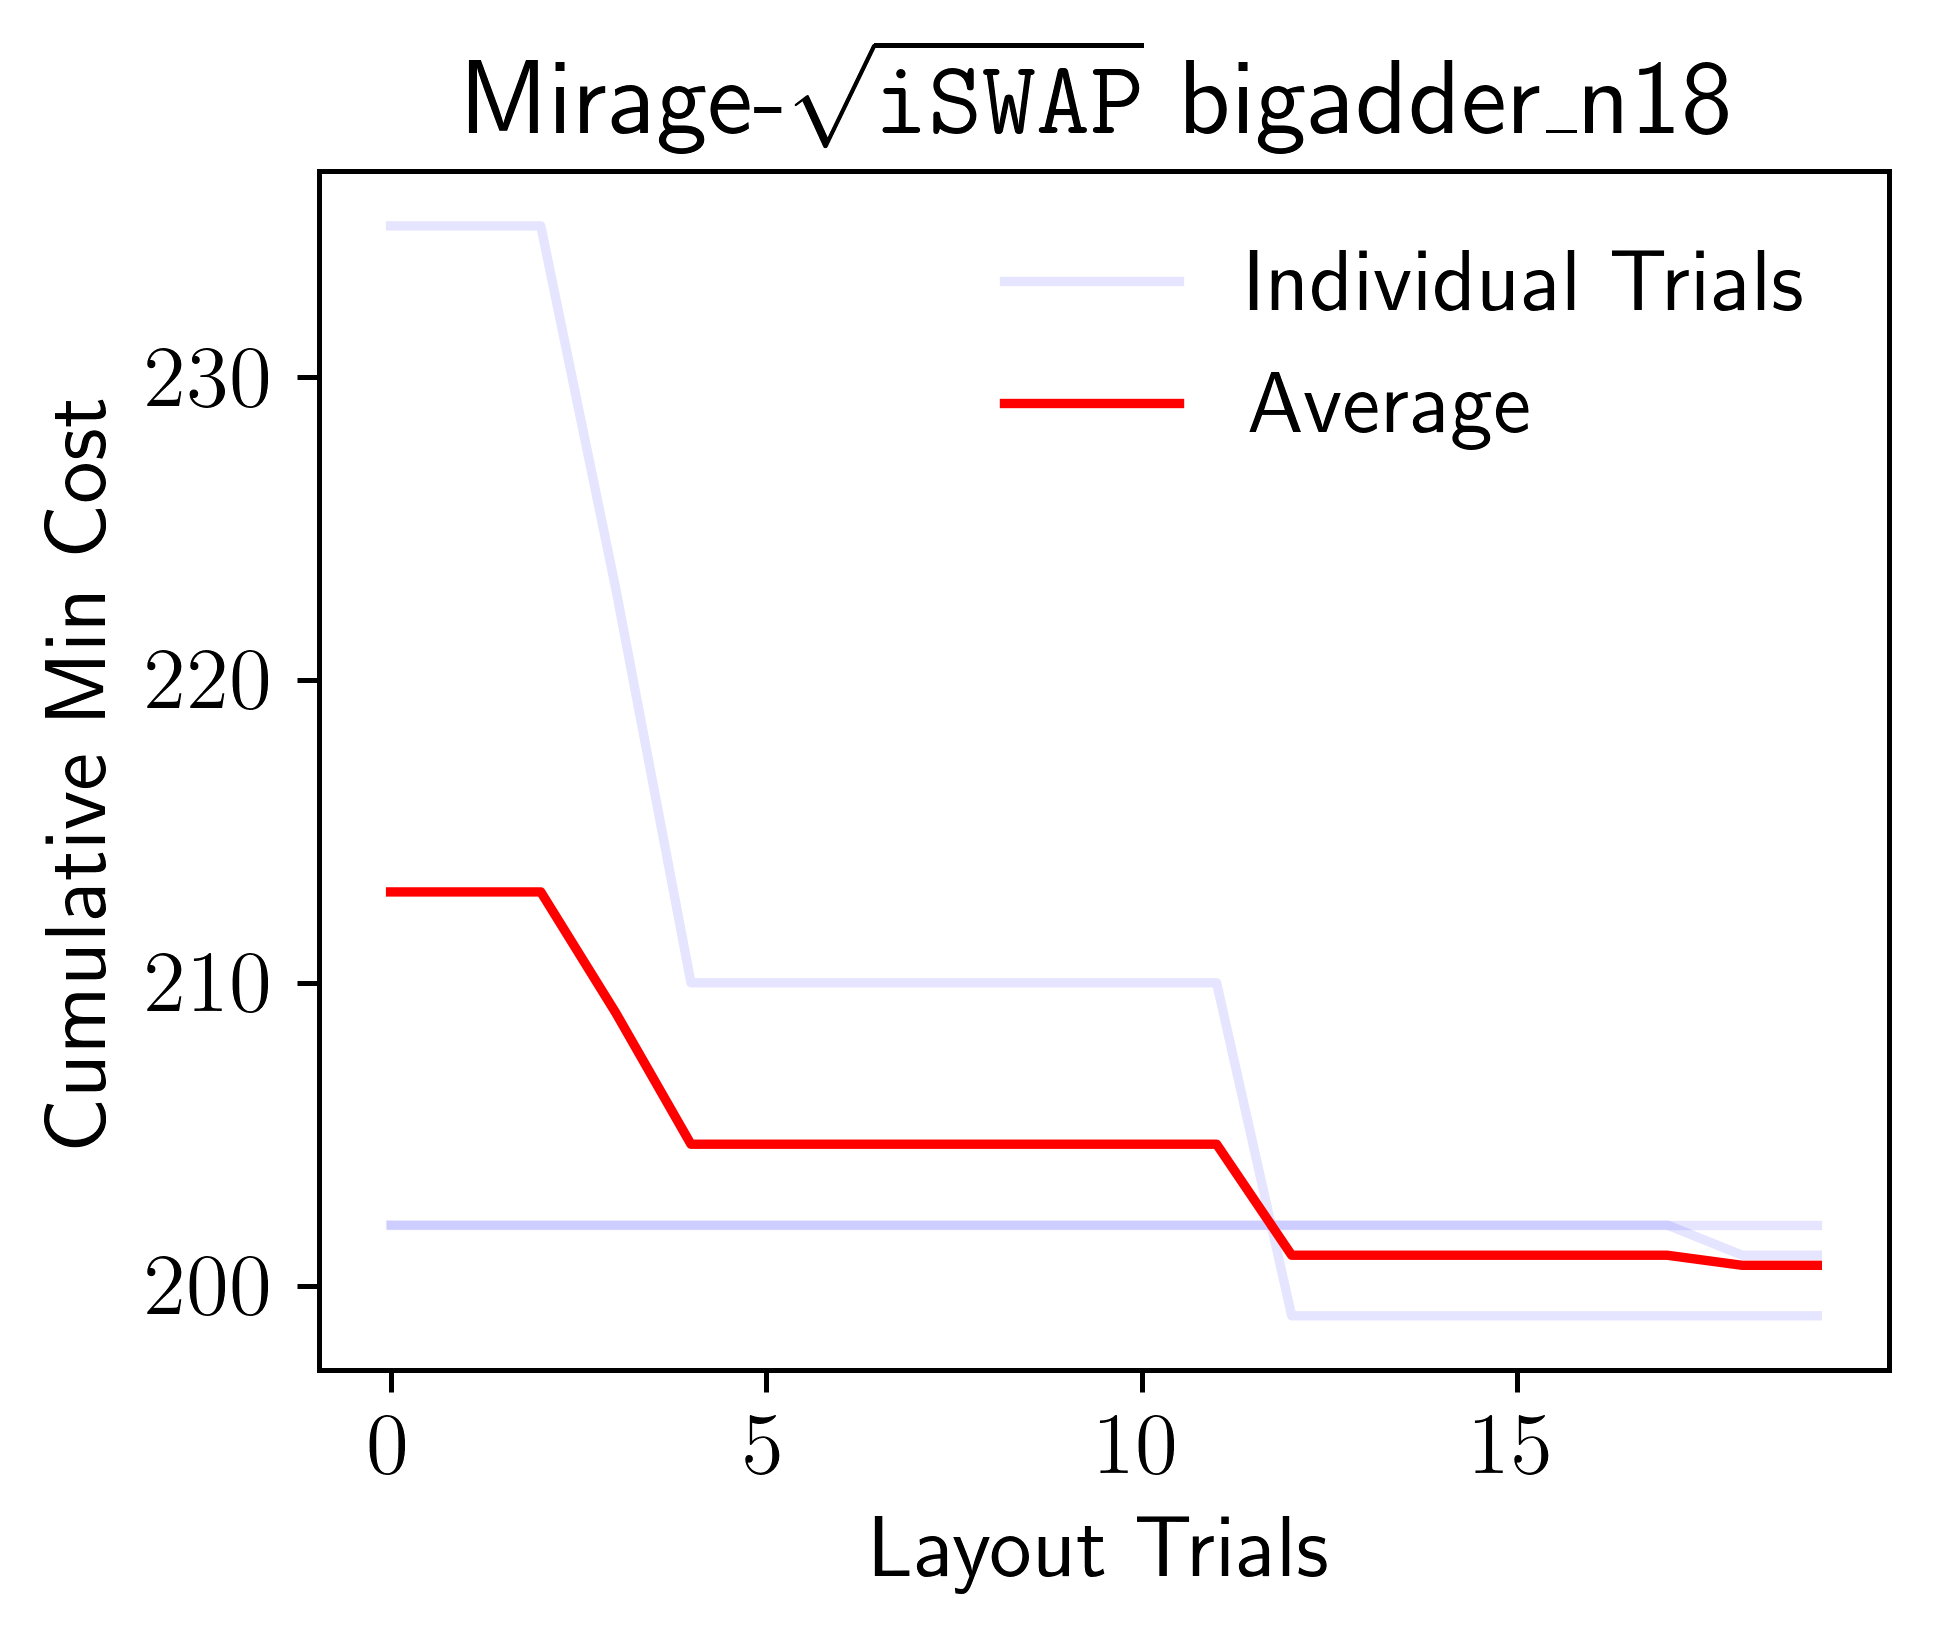

Mirage-b3-$\sqrt{\texttt{iSWAP}}$
(3, 20)


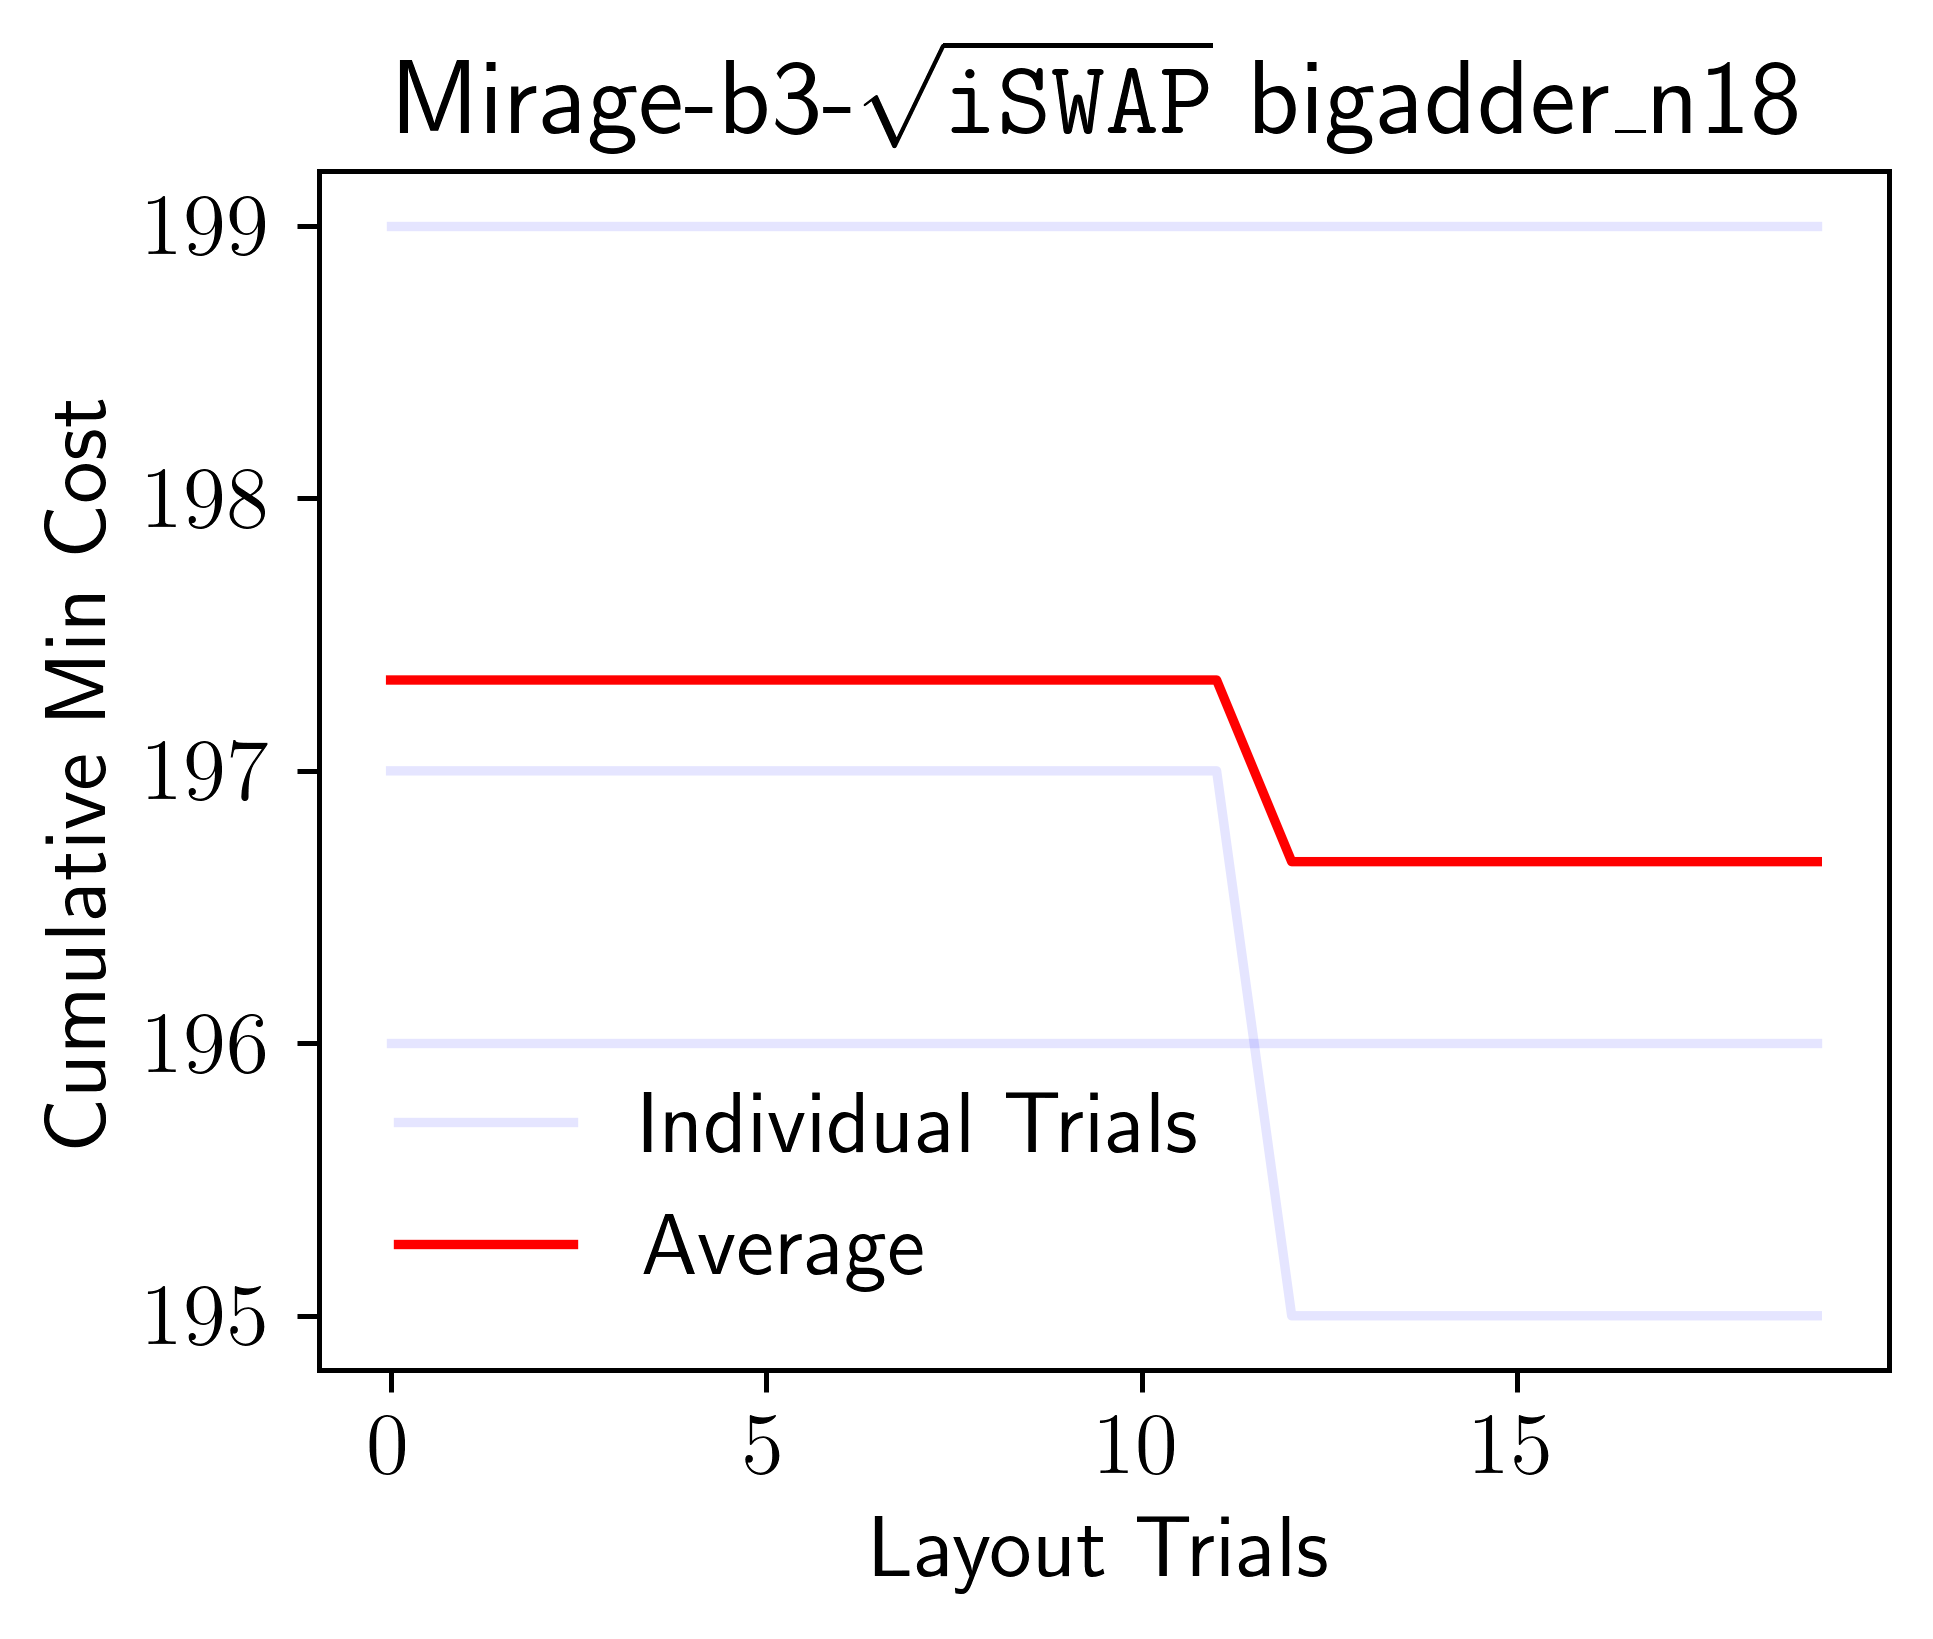

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming benchmark.metrics[0].saved_results.items() is a dictionary
# where keys are circuit names and values are lists of costs for each trial
for k, v in benchmark.metrics[0].saved_results.items():
    print(k)
    for circuit, result in v.items():
        # print(circuit)
        # print(result.data)

        # find cumulative min trial-wise
        min_trials = np.minimum.accumulate(result.data, axis=1)
        print(min_trials.shape)
        # print(min_trials)

        # average element-wise across all trials
        avg = np.mean(min_trials, axis=0)
        # print(avg)

        # plot cumulative min vs trial
        # also plot average cumulative min vs trial
        # at each trial we also want to scatter plot each individual trial,

        # plot with latex
        with plt.style.context(["ipynb", "colorsblind10"]):
            plt.rcParams["text.usetex"] = True
            for j, trials in enumerate(min_trials):
                plt.plot(
                    trials,
                    color="blue",
                    alpha=0.1,
                    label="Individual Trials" if j == 0 else None,
                )
            plt.plot(avg, color="red", label="Average")
            plt.xlabel("Layout Trials")
            plt.ylabel("Cumulative Min Cost")
            plt.title(f"{k} {circuit}")
            plt.ticklabel_format(style="plain")  # Turn off scientific notation
            plt.legend()
            plt.show()

In [ ]:
# # explictly print results
# for k, v in benchmark.metrics[0].saved_results.items():
#     for circuit, result in v.items():
#         print(result.data)